# Imports and configs

In [1]:
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from scipy.stats import pearsonr
from xgboost import XGBRegressor
from sklearn.base import clone
# from koolbox import Trainer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import optuna
import joblib
import glob
import gc

warnings.filterwarnings("ignore")

In [2]:
class CFG:
    train_path = "input/train.parquet"
    test_path = "input/test.parquet"
    sample_sub_path = "input/sample_submission.csv"

    target = "label"
    n_folds = 5
    seed = 42

    run_optuna = True
    n_optuna_trials = 100 

# Data loading

Discussionで拾ってきたやつ。データ量を圧縮して分析効率を上げることができる。
https://www.kaggle.com/competitions/drw-crypto-market-prediction/discussion/580485

In [3]:
def reduce_mem_usage(dataframe, dataset):    
    print('Reducing memory usage for:', dataset)
    initial_mem_usage = dataframe.memory_usage().sum() / 1024**2

    for col in dataframe.columns:
        col_type = dataframe[col].dtype

        c_min = dataframe[col].min()
        c_max = dataframe[col].max()
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                dataframe[col] = dataframe[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                dataframe[col] = dataframe[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                dataframe[col] = dataframe[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                dataframe[col] = dataframe[col].astype(np.int64)
        else:
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                dataframe[col] = dataframe[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                dataframe[col] = dataframe[col].astype(np.float32)
            else:
                dataframe[col] = dataframe[col].astype(np.float64)

    final_mem_usage = dataframe.memory_usage().sum() / 1024**2
    print('--- Memory usage before: {:.2f} MB'.format(initial_mem_usage))
    print('--- Memory usage after: {:.2f} MB'.format(final_mem_usage))
    print('--- Decreased memory usage by {:.1f}%\n'.format(100 * (initial_mem_usage - final_mem_usage) / initial_mem_usage))

    return dataframe


In [5]:
train = pd.read_parquet(CFG.train_path).reset_index(drop=True)
test = pd.read_parquet(CFG.test_path).reset_index(drop=True)

train = reduce_mem_usage(train, "train")
test = reduce_mem_usage(test, "test")

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]
X_test = test.drop(CFG.target, axis=1)

Reducing memory usage for: train
--- Memory usage before: 3594.93 MB
--- Memory usage after: 961.92 MB
--- Decreased memory usage by 73.2%

Reducing memory usage for: test
--- Memory usage before: 3678.76 MB
--- Memory usage after: 984.36 MB
--- Decreased memory usage by 73.2%



# EDA

In [6]:
train.head()

,bid_qty,ask_qty,buy_qty,sell_qty,volume,X1,X2,X3,X4,X5,...,X882,X883,X884,X885,X886,X887,X888,X889,X890,label
0,15.281250,8.421875,176.3750,44.96875,221.375,0.121277,-0.417725,0.005398,0.125977,0.058350,...,1.925781,1.847656,0.005676,0.190796,0.369629,0.377686,0.210205,0.159180,0.530762,0.562500
1,38.593750,2.335938,526.0000,322.00000,848.000,0.302734,-0.049561,0.356689,0.481201,0.237915,...,1.928711,1.849609,0.005226,0.184692,0.363525,0.374512,0.209595,0.158936,0.530273,0.533691
2,0.441895,60.250000,159.2500,136.37500,295.500,0.167480,-0.291260,0.083130,0.206909,0.101746,...,1.927734,1.849609,0.004795,0.178711,0.357666,0.371338,0.208984,0.158691,0.529785,0.546387
3,4.863281,21.015625,335.7500,124.93750,460.750,0.072937,-0.436523,-0.102478,0.017548,0.007149,...,1.928711,1.849609,0.004398,0.172974,0.351807,0.368408,0.208374,0.158569,0.529297,0.357666
4,27.156250,3.451172,98.4375,44.40625,142.875,0.173828,-0.213501,0.096069,0.215698,0.107117,...,1.926758,1.848633,0.004009,0.167358,0.345947,0.365234,0.207886,0.158325,0.529297,0.362549


### 目的変数
label：将来のマーケットのボラティリティを表す連続値

#### 目的変数の分布

In [7]:
y.describe()

count    525887.000000
mean          0.000000
std           0.000000
min         -24.421875
25%          -0.381592
50%           0.016266
75%           0.434082
max          20.734375
Name: label, dtype: float64

<Axes: xlabel='label', ylabel='Count'>

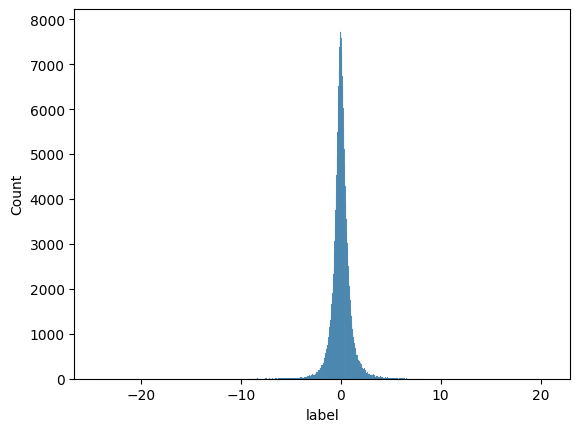

In [8]:
sns.histplot(y.astype(np.float32))

基本的に±0.5の中に収まるような分布をしている。

#### 1min刻みの全データ

<Axes: xlabel='None', ylabel='label'>

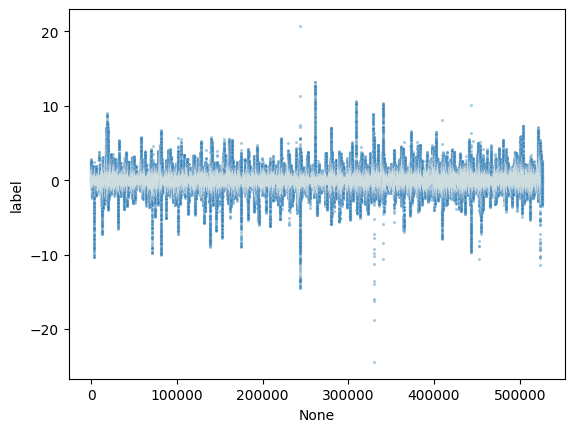

In [9]:
sns.scatterplot(x=train.index, y=train[CFG.target], alpha=0.4, s=5)

2023/3/1~2024/2/29までの全データ

基本的には安定している。たまに大きく振れることがある様子。→イベントごとで動きあり？

#### 時系列データとして分析してみる

In [11]:
timestamps = pd.date_range(start="2023-03-01 00:00:00",
                           periods=525_887,
                           freq='T')

train_addtime = train.copy()
train_addtime.index = timestamps
train_addtime['date']    = train_addtime.index.date
train_addtime['time']    = train_addtime.index.time
train_addtime['hour']    = train_addtime.index.hour
train_addtime['minute']  = train_addtime.index.minute
train_addtime['weekday'] = train_addtime.index.day_name()  # 英語曜日

train_addtime.head()

,bid_qty,ask_qty,buy_qty,sell_qty,volume,X1,X2,X3,X4,X5,...,X887,X888,X889,X890,label,date,time,hour,minute,weekday
2023-03-01 00:00:00,15.281250,8.421875,176.3750,44.96875,221.375,0.121277,-0.417725,0.005398,0.125977,0.058350,...,0.377686,0.210205,0.159180,0.530762,0.562500,2023-03-01,00:00:00,0,0,Wednesday
2023-03-01 00:01:00,38.593750,2.335938,526.0000,322.00000,848.000,0.302734,-0.049561,0.356689,0.481201,0.237915,...,0.374512,0.209595,0.158936,0.530273,0.533691,2023-03-01,00:01:00,0,1,Wednesday
2023-03-01 00:02:00,0.441895,60.250000,159.2500,136.37500,295.500,0.167480,-0.291260,0.083130,0.206909,0.101746,...,0.371338,0.208984,0.158691,0.529785,0.546387,2023-03-01,00:02:00,0,2,Wednesday
2023-03-01 00:03:00,4.863281,21.015625,335.7500,124.93750,460.750,0.072937,-0.436523,-0.102478,0.017548,0.007149,...,0.368408,0.208374,0.158569,0.529297,0.357666,2023-03-01,00:03:00,0,3,Wednesday
2023-03-01 00:04:00,27.156250,3.451172,98.4375,44.40625,142.875,0.173828,-0.213501,0.096069,0.215698,0.107117,...,0.365234,0.207886,0.158325,0.529297,0.362549,2023-03-01,00:04:00,0,4,Wednesday


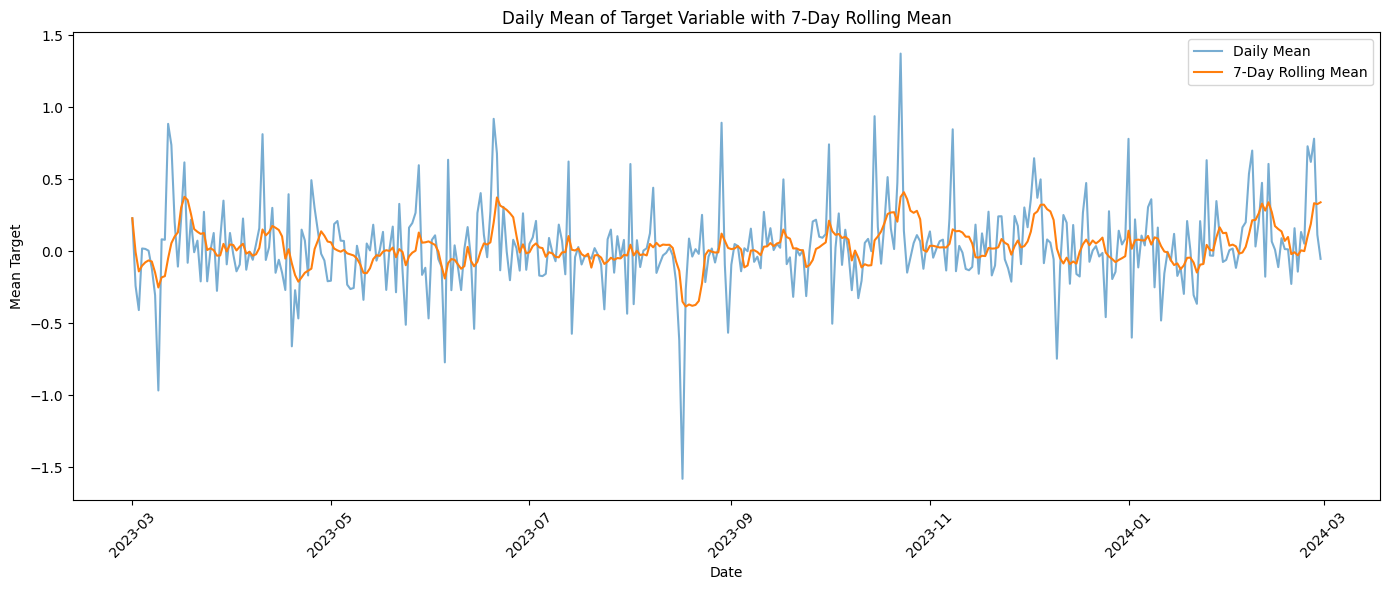

In [13]:
daily = train_addtime.groupby('date')[CFG.target].agg(['mean','sum','median','max'])

plt.figure(figsize=(14, 6))

# 元の日次平均
sns.lineplot(x=daily.index, y=daily['mean'], label='Daily Mean', alpha=0.6)

# 7日移動平均（トレンド把握用）
daily['mean_7d'] = daily['mean'].rolling(window=7, min_periods=1).mean()
sns.lineplot(x=daily.index, y=daily['mean_7d'], label='7-Day Rolling Mean')

plt.title('Daily Mean of Target Variable with 7-Day Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Mean Target')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

なんとなく周期性はありそう。

<Axes: xlabel='weekday', ylabel='label'>

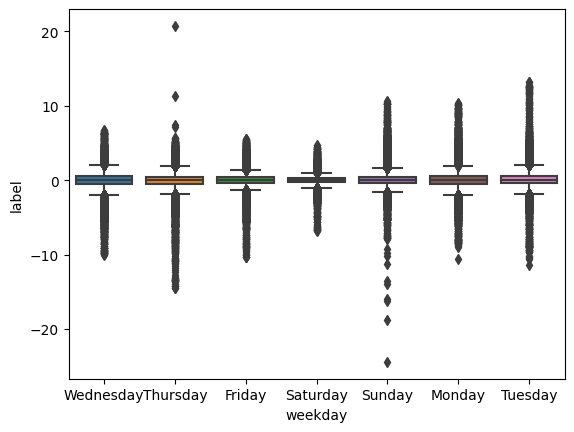

In [16]:
sns.boxplot(x='weekday', y=CFG.target, data=train_addtime)

土曜はあまりぶれない。日曜は下振れしがち。

<Axes: xlabel='weekday'>

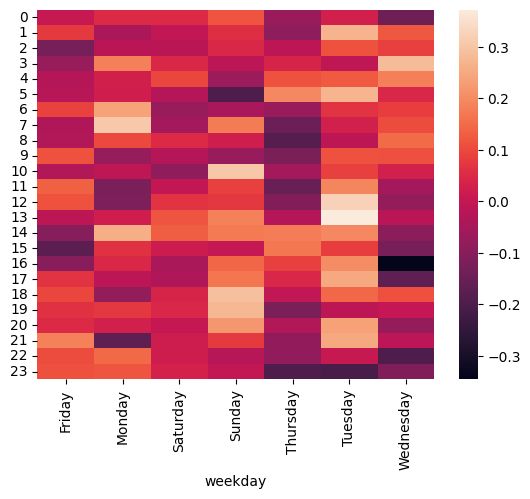

In [17]:
pivot = train_addtime.pivot_table(index=train_addtime.index.hour,
                       columns=train_addtime.weekday,
                       values=CFG.target,
                       aggfunc='mean')
sns.heatmap(pivot)


ちょっとよくわからん

#### 周期性を定量的に捉える

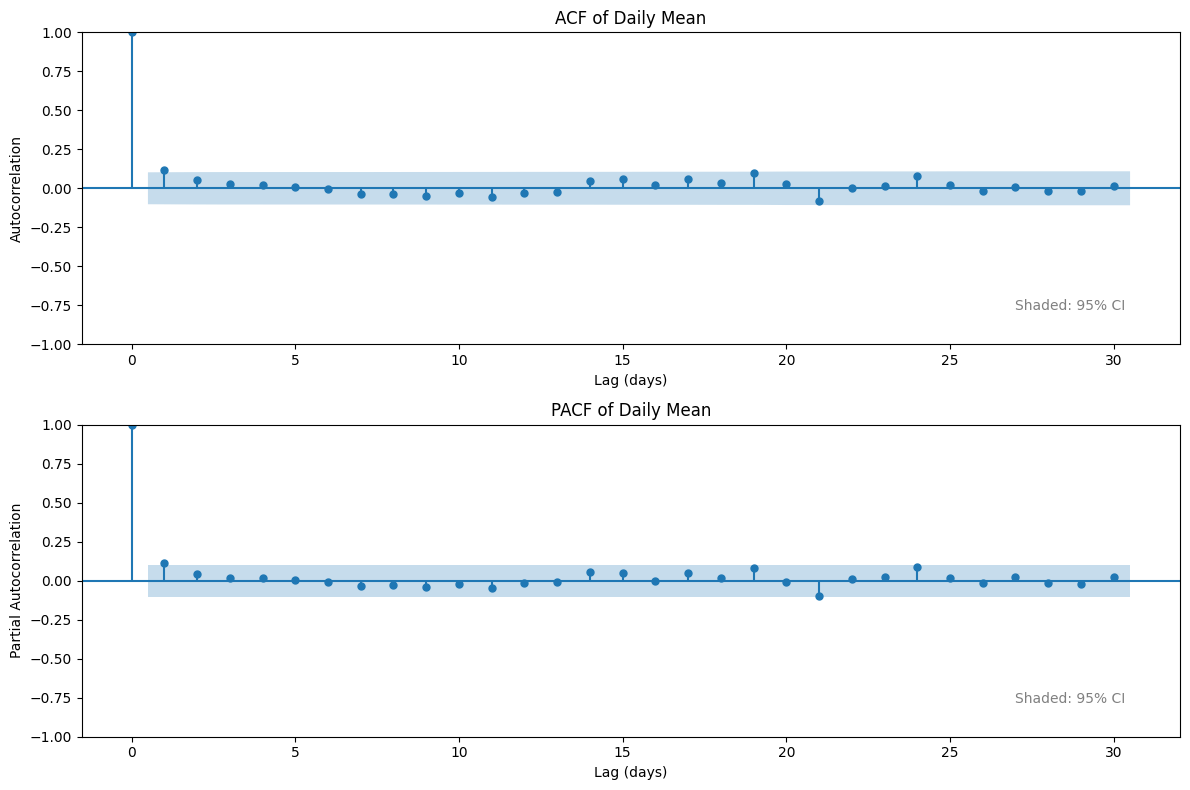

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# ACF
plot_acf(daily['mean'], lags=30, ax=axes[0], title='ACF of Daily Mean')
axes[0].set_xlabel('Lag (days)')                  # 横軸ラベル
axes[0].set_ylabel('Autocorrelation')             # 縦軸ラベル
axes[0].text(0.95, 0.1, 'Shaded: 95% CI',          # 信頼区間注釈
             transform=axes[0].transAxes,
             ha='right', va='bottom', color='gray')

# PACF
plot_pacf(daily['mean'], lags=30, ax=axes[1], title='PACF of Daily Mean')
axes[1].set_xlabel('Lag (days)')
axes[1].set_ylabel('Partial Autocorrelation')
axes[1].text(0.95, 0.1, 'Shaded: 95% CI',
             transform=axes[1].transAxes,
             ha='right', va='bottom', color='gray')

plt.tight_layout()
plt.show()

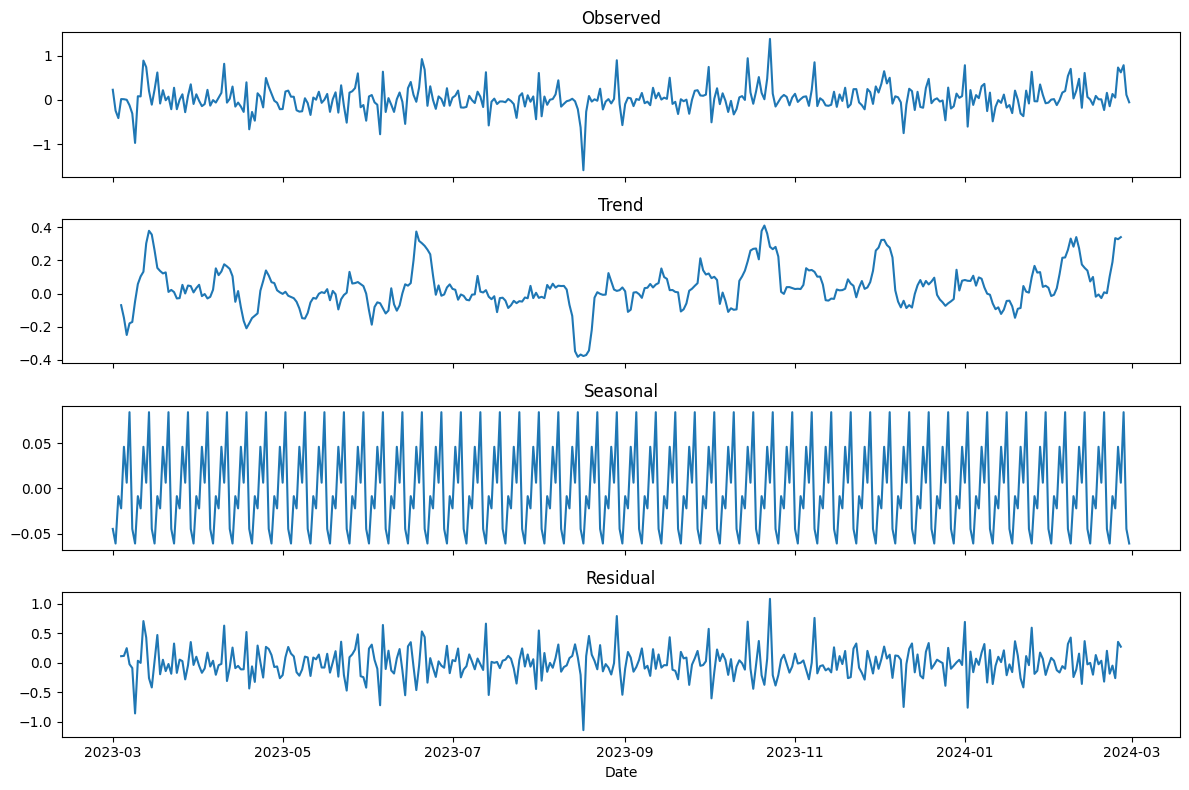

In [25]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# 日次平均を日付インデックスに補完＆補間
series = daily['mean'].asfreq('D').interpolate()

# 週次 (period=7) で分解
res = seasonal_decompose(series, model='additive', period=7)

# ── 4行×1列 のサブプロットを横長に作成 ──
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

# 各成分をプロット
axes[0].plot(series)
axes[0].set_title('Observed')

axes[1].plot(res.trend)
axes[1].set_title('Trend')

axes[2].plot(res.seasonal)
axes[2].set_title('Seasonal')

axes[3].plot(res.resid)
axes[3].set_title('Residual')

# 共通の X 軸ラベル
axes[3].set_xlabel('Date')

plt.tight_layout()
plt.show()


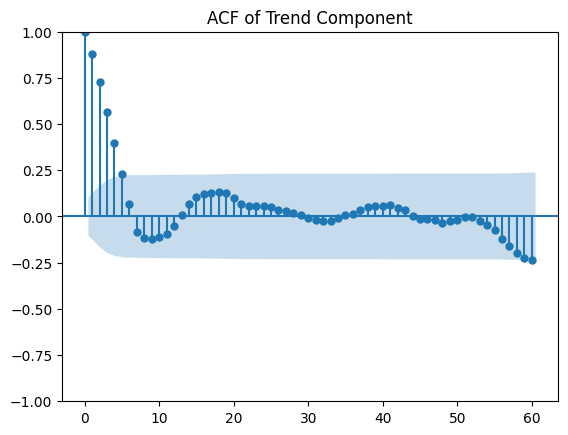

In [26]:
plot_acf(res.trend.dropna(), lags=60)
plt.title("ACF of Trend Component")
plt.show()

周期性ありそうだと思ったが、そうでもなかった。